In [1]:
"""This project is built for preference recommendation. 

Original training data (first column is user id, second column is movie id, 
third column is rating. To simplify the problem, only considering rating = 1
as "like", rating = -1 as "dislike") has been offered. 

The goal is to predict users' preference on thoes movies they haven't watched
yet and recommend highest rating movies to them. 

By comparing the test data with ground truth in the same format as training data,
the confusion matrix containing true/false positives/negatives can be calculated 
and the accuracy of used algorithm can be estimated. 
"""

import numpy as np
import pandas as pd

data_test = pd.read_csv('/Users/easonlian/Desktop/programming/bayesianml/ratings_test.csv', header=None)
data_train = pd.read_csv('/Users/easonlian/Desktop/programming/bayesianml/ratings.csv', header=None)

npdata_train= data_train.values
print data_test.head()
print data_train.head()

     0    1  2
0  617  590 -1
1  836   12  1
2  933  239 -1
3   85  622 -1
4  886  204 -1
     0    1  2
0  196  242 -1
1  186  302 -1
2  244   51 -1
3  166  346 -1
4  298  474  1


In [2]:
"""Use Expectation-Maximization Algorithm for object recommendation problem. Assume that rating 
follows Bernoulli distribution and the unknown model parameters ui, vj (u: user id; v: movie id)
follow normal distributions. By maximizing the posterior probability lnP(R,U,V), the unknown
parameter U, V can be well estimated.
"""

#Store all data pairs in a dictionary so we can get the key and value very fast
N = max(data_train[0])
M = max(data_train[1])
dic = {}
Edic = {}
ijpair = {}
jipair = {}
length = len(npdata_train)
for i in range(length):
    u_id = npdata_train[i, 0]
    v_id = npdata_train[i, 1]
    rij = npdata_train[i, 2]
    dic[(u_id, v_id)] = rij
    Edic[(u_id, v_id)] = 0
    if u_id not in ijpair:
        ijpair[u_id] = [v_id]
    else: 
        ijpair[u_id] = ijpair[u_id] + [v_id]
    if v_id not in jipair:
        jipair[v_id] = [u_id]
    else: 
        jipair[v_id] = jipair[v_id] + [u_id]

In [3]:
#Initialize U, V. We assume the prior probability of U, V follows normal distribution 
d = 5
Umatrix = [np.random.normal(0, np.sqrt(0.1), d) for x in range(N+1)]
Vmatrix = [np.random.normal(0, np.sqrt(0.1), d) for x in range(M+1)]

In [4]:
newN = len(ijpair)
newM = len(jipair)

In [5]:
#As Expectation-Maximization Algorithm indicates, we use iteration to update lnP(R,U,V).
#Now begin iteration t = 1, 2, ..., T
from scipy.stats import norm
LNP = []
for t in range(100):
    #update Eqt[phi]
    S1 = []
    S2 = []
    for key in dic:
        i = key[0]
        j = key[1]
        r = dic[key]
        dot = np.dot(Umatrix[i], Vmatrix[j])
        sigma = 1
        s = -dot/sigma
        if r == 1: S1.append(s)
        if r == -1: S2.append(s)
    E1 = np.array(S1)*(-sigma)+sigma*norm.pdf(S1)/(1-norm.cdf(S1))
    E2 = np.array(S2)*(-sigma)+sigma*(-1)*norm.pdf(S2)/norm.cdf(S2)
    i1 = 0
    i2 = 0
    for key in dic:
        r = dic[key]
        if r == 1: 
            Edic[key] = E1[i1]
            i1 = i1+1
        if r == -1: 
            Edic[key] = E2[i2]
            i2 = i2+1
    
    #update U
    for uitem in ijpair:
        c = 1
        vsum = 0
        vEsum = 0
        for vitem in ijpair[uitem]:
            vsum = vsum + np.outer(Vmatrix[vitem], Vmatrix[vitem])/(sigma)**2
            vEsum = vEsum + Vmatrix[vitem] * Edic[(uitem, vitem)]/(sigma)**2
        
        Umatrix[uitem] = np.dot(np.linalg.inv((np.identity(d) + vsum)), vEsum)
    
    #update Eqt[phi] again
    S1 = []
    S2 = []
    for key in dic:
        i = key[0]
        j = key[1]
        r = dic[key]
        dot = np.dot(Umatrix[i], Vmatrix[j])
        sigma = 1
        s = -dot/sigma
        if r == 1: S1.append(s)
        if r == -1: S2.append(s)
    E1 = np.array(S1)*(-sigma)+sigma*norm.pdf(S1)/(1-norm.cdf(S1))
    E2 = np.array(S2)*(-sigma)+sigma*(-1)*norm.pdf(S2)/norm.cdf(S2)
    i1 = 0
    i2 = 0
    for key in dic:
        r = dic[key]
        if r == 1: 
            Edic[key] = E1[i1]
            i1 = i1+1
        if r == -1: 
            Edic[key] = E2[i2]
            i2 = i2+1
        
    #update V
    for vitem in jipair:
        c = 1
        usum = 0
        uEsum = 0
        for uitem in jipair[vitem]:
            usum = usum + np.outer(Umatrix[uitem], Umatrix[uitem])/(sigma)**2
            uEsum = uEsum + Umatrix[uitem] * Edic[(uitem, vitem)]/(sigma)**2
        
        Vmatrix[vitem] = np.dot(np.linalg.inv((np.identity(d) + usum)), uEsum)
    
    
    #calculate lnP(R, U, V)
    sum1 = -newN*d/2*np.log(2*np.pi*c)
    sum2 = 0
    for uitem in ijpair:
        sum2 = sum2 - np.dot(Umatrix[uitem], Umatrix[uitem])/2/c
    sum3 = -newM*d/2*np.log(2*np.pi*c)
    sum4 = 0
    for vitem in jipair:
        sum4 = sum4 - np.dot(Vmatrix[vitem], Vmatrix[vitem])/2/c
    sum5 = 0
    S1 = []
    S2 = []
    for key in dic:
        i = key[0]
        j = key[1]
        r = dic[key]
        dot = np.dot(Umatrix[i], Vmatrix[j])
        sigma = 1
        s = dot/sigma
        if r == 1: S1.append(s)
        if r == -1: S2.append(s)
    sum5 = sum5 + sum(np.log(norm.cdf(S1))) + sum(np.log(1-norm.cdf(S2)))
    lnP = sum1 + sum2 + sum3 + sum4 + sum5
    LNP.append(lnP)
    

Text(0,0.5,'Ln P')

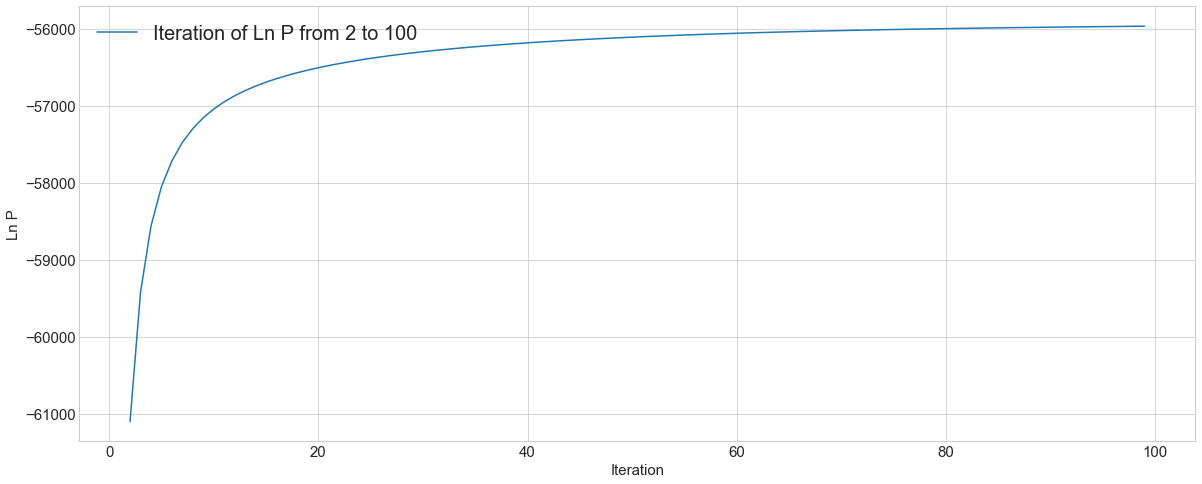

In [6]:
#plot lnP(R,U,V) from iteration 2 to 100. It can be shown that the value of lnP(R,U,V) converges after
#a long time iterations. 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [20, 8]
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(range(2,100), LNP[2:])
plt.legend(['Iteration of Ln P from 2 to 100'], prop={'size': 20})
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Ln P', fontsize=15)

In [7]:
#Use updated U, V to predict user preference and get the confusion matrix.
npdata_test = data_test.values
test_length = len(npdata_test)
prediction_list = []
#calculate lnP(rij, uij, vij)
for i in range(test_length):
    ui = npdata_test[i, 0]
    vj = npdata_test[i, 1]
    dot = np.dot(Umatrix[ui], Vmatrix[vj])
    sigma = 1
    s = dot/sigma
    pr1 = np.log(norm.cdf(s))
    pr2 = np.log(1-norm.cdf(s))
    if pr1 > pr2:
        prediction_list.append(1)
    else: prediction_list.append(-1)
        
count_22 = 0 # ground-truth is -1, prediction is -1 
count_21 = 0 # groud-truth is -1, prediction is 1
count_12 = 0 # groud-truth is 1, prediction is -1
count_11 = 0 # groud-truth is 1, prediciton is 1

for i in range(test_length):
    if npdata_test[i, 2] == 1 and prediction_list[i] == 1: count_11 = count_11 + 1
    if npdata_test[i, 2] == 1 and prediction_list[i] == -1: count_12 = count_12 + 1
    if npdata_test[i, 2] == -1 and prediction_list[i] == 1: count_21 = count_21 + 1
    if npdata_test[i, 2] == -1 and prediction_list[i] == -1: count_22 = count_22 + 1
    
print (count_11, count_12, count_21, count_22)


(2144, 590, 838, 1428)


In [8]:
#Calculate accuracy of EM algorithm.
accuracy = (count_11 + count_22)*1.0/(count_11 + count_12 + count_21 + count_22)
print accuracy

0.7144
